# Heritability Analysis

As an application of the variance component model, this note demonstrates the workflow for heritability analysis in genetics, using a sample data set `cg10k` with **6,670** individuals and **630,860** SNPs. Person IDs and phenotype names are masked for privacy. `cg10k.bed`, `cg10k.bim`, and `cg10k.fam` is a set of Plink files in binary format. `cg10k_traits.txt` contains 13 phenotypes of the 6,670 individuals.

In [1]:
;ls cg10k*.*

cg10k.bed
cg10k.bim
cg10k.fam
cg10k_traits.txt


Machine information:

In [2]:
versioninfo()

Julia Version 0.5.1
Commit 6445c82 (2017-03-05 13:25 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin13.4.0)
  CPU: Intel(R) Core(TM) i7-4790K CPU @ 4.00GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, haswell)


## Read in binary SNP data

We will use the [`SnpArrays.jl`](https://github.com/OpenMendel/SnpArrays.jl) package to read in binary SNP data and compute the empirical kinship matrix. Issue 
```julia
Pkg.clone("https://github.com/OpenMendel/SnpArrays.jl.git")
```
within `Julia` to install the `SnpArrays` package.

In [5]:
using SnpArrays

In [6]:
# read in genotype data from Plink binary file (~50 secs on my laptop)
@time cg10k = SnpArray("cg10k")

 33.883711 seconds (282.07 k allocations: 1015.002 MB, 0.23% gc time)


6670×630860 SnpArrays.SnpArray{2}:
 (false,true)   (false,true)   (true,true)   …  (true,true)    (true,true) 
 (true,true)    (true,true)    (false,true)     (false,true)   (true,false)
 (true,true)    (true,true)    (false,true)     (true,true)    (true,true) 
 (true,true)    (true,true)    (true,true)      (false,true)   (true,true) 
 (true,true)    (true,true)    (true,true)      (true,true)    (false,true)
 (false,true)   (false,true)   (true,true)   …  (true,true)    (true,true) 
 (false,false)  (false,false)  (true,true)      (true,true)    (true,true) 
 (true,true)    (true,true)    (true,true)      (true,true)    (false,true)
 (true,true)    (true,true)    (false,true)     (true,true)    (true,true) 
 (true,true)    (true,true)    (true,true)      (false,true)   (true,true) 
 (true,true)    (true,true)    (false,true)  …  (true,true)    (true,true) 
 (false,true)   (false,true)   (true,true)      (true,true)    (false,true)
 (true,true)    (true,true)    (true,true)      (true

## Summary statistics of SNP data

In [7]:
people, snps = size(cg10k)

(6670,630860)

In [8]:
# summary statistics (~50 secs on my laptop)
@time maf, _, missings_by_snp, = summarize(cg10k);

 26.436140 seconds (33.44 k allocations: 10.920 MB)


In [9]:
# 5 number summary and average MAF (minor allele frequencies)
quantile(maf, [0.0 .25 .5 .75 1.0]), mean(maf)

(
[0.00841726 0.124063 … 0.364253 0.5],

0.24536516625042462)


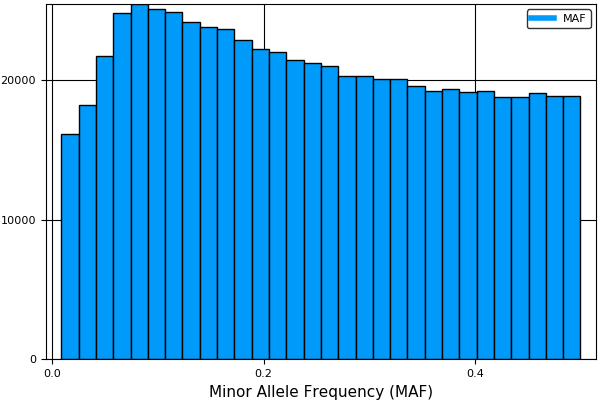

In [13]:
# Pkg.add("Plots")
# Pkg.add("PyPlot")
using Plots
pyplot()

histogram(maf, xlab = "Minor Allele Frequency (MAF)", label = "MAF")

In [14]:
# proportion of missing genotypes
sum(missings_by_snp) / length(cg10k)

0.0013128198764010824

In [15]:
# proportion of rare SNPs with maf < 0.05
countnz(maf .< 0.05) / length(maf)

0.07228069619249913

## Empirical kinship matrix

We estimate empirical kinship based on all SNPs by the genetic relation matrix (GRM). Missing genotypes are imputed on the fly by drawing according to the minor allele frequencies.

In [16]:
# GRM using all SNPs (~10 mins on my laptop)
srand(123)
@time Φgrm = grm(cg10k; method = :GRM)

2099.911248 seconds (29.50 G allocations: 441.429 GB, 1.50% gc time)


6670×6670 Array{Float64,2}:
  0.502916      0.00329978   -0.000116213  …  -6.46286e-5   -0.00281229 
  0.00329978    0.49892      -0.00201992       0.000909871   0.00345573 
 -0.000116213  -0.00201992    0.493632         0.000294565  -0.000349854
  0.000933977  -0.00320391   -0.0018611       -0.00241682   -0.00127078 
 -7.75429e-5   -0.0036075     0.00181442       0.00213976   -0.00158382 
  0.00200371    0.000577386   0.0025455    …   0.000943753  -1.82994e-6 
  0.000558503   0.00241421   -0.0018782        0.001217     -0.00123924 
 -0.000659495   0.00319987   -0.00101496       0.00353646   -0.00024093 
 -0.00102619   -0.00120448   -0.00055462       0.00175586    0.00181899 
 -0.00136838    0.00211996    0.000119128     -0.00147305   -0.00105239 
 -0.00206144    0.000148818  -0.000475177  …  -0.000265522  -0.00106123 
  0.000951016   0.00167042    0.00183545      -0.000703658  -0.00313334 
  0.000330442  -0.000904147   0.00301478       0.000754772  -0.00127413 
  ⋮                    

## Phenotypes

Read in the phenotype data and compute descriptive statistics.

In [20]:
# Pkg.add("DataFrames")
using DataFrames

cg10k_trait = readtable(
    "cg10k_traits.txt"; 
    separator = ' ',
    names = [:FID; :IID; :Trait1; :Trait2; :Trait3; :Trait4; :Trait5; :Trait6; 
             :Trait7; :Trait8; :Trait9; :Trait10; :Trait11; :Trait12; :Trait13],  
    eltypes = [String; String; Float64; Float64; Float64; Float64; Float64; 
               Float64; Float64; Float64; Float64; Float64; Float64; Float64; Float64]
    )
# do not display FID and IID for privacy
cg10k_trait[:, 3:end]

,Trait1,Trait2,Trait3,Trait4,Trait5,Trait6,Trait7,Trait8,Trait9,Trait10,Trait11,Trait12,Trait13
1,-1.81573145026234,-0.94615046147283,1.11363077580442,-2.09867121119159,0.744416614111748,0.00139171884080131,0.934732480409667,-1.22677315418103,1.1160784277875,-0.4436280335029,0.824465656443384,-1.02852542216546,-0.394049201727681
2,-1.24440094378729,0.109659992547179,0.467119394241789,-1.62131304097589,1.0566758355683,0.978946979419181,1.00014633946047,0.32487427140228,1.16232175219696,2.6922706948705,3.08263672461047,1.09064954786013,0.0256616415357438
3,1.45566914502305,1.53866932923243,1.09402959376555,0.586655272226893,-0.32796454430367,-0.30337709778827,-0.0334354881314741,-0.464463064285437,-0.3319396273436,-0.486839089635991,-1.10648681564373,-1.42015780427231,-0.687463456644413
4,-0.768809276698548,0.513490885514249,0.244263028382142,-1.31740254475691,1.19393774326845,1.17344127734288,1.08737426675232,0.536022583732261,0.802759240762068,0.234159411749815,0.394174866891074,-0.767365892476029,0.0635385761884935
5,-0.264415132547719,-0.348240421825694,-0.0239065083413606,0.00473915802244948,1.25619191712193,1.2038883667631,1.29800739042627,0.310113660247311,0.626159861059352,0.899289129831224,0.54996783350812,0.540687809542048,0.179675416046033
6,-1.37617270917293,-1.47191967744564,0.291179894254146,-0.803110740704731,-0.264239977442213,-0.260573027836772,-0.165372266287781,-0.219257294118362,1.04702422290318,-0.0985815534616482,0.947393438068448,0.594014812031438,0.245407436348479
7,0.1009416296374,-0.191615722103455,-0.567421321596677,0.378571487240382,-0.246656179817904,-0.608810750053858,0.189081058215596,-1.27077787326519,-0.452476199143965,0.702562877297724,0.332636218957179,0.0026916503626181,0.317117176705358
8,-0.319818276367464,1.35774480657283,0.818689545938528,-1.15565531644352,0.63448368102259,0.291461908634679,0.933323714954726,-0.741083289682492,0.647477683507572,-0.970877627077966,0.220861165411304,0.852512250237764,-0.225904624283945
9,-0.288334173342032,0.566082538090752,0.254958336116175,-0.652578302869714,0.668921559277347,0.978309199170558,0.122862966041938,1.4790926378214,0.0672132424173449,0.0795903917527827,0.167532455243232,0.246915579442139,0.539932616458363
10,-1.15759732583991,-0.781198583545165,-0.595807759833517,-1.00554980260402,0.789828885933321,0.571058413379044,0.951304176233755,-0.295962982984816,0.99042002479707,0.561309366988983,0.733100030623233,-1.73467772245684,-1.35278484330654


In [21]:
describe(cg10k_trait[:, 3:end])

Trait1
Min      -3.2041280147118
1st Qu.  -0.645770976594801
Median   0.12500996951180798
Mean     0.0022113846331389903
3rd Qu.  0.7233154897636109
Max      3.47939787136478
NAs      0
NA%      0.0%

Trait2
Min      -3.51165862877157
1st Qu.  -0.6426205239938769
Median   0.0335172506981786
Mean     0.0013525291443179934
3rd Qu.  0.6574666174104795
Max      4.91342267449592
NAs      0
NA%      0.0%

Trait3
Min      -3.93843646263987
1st Qu.  -0.6409067201835312
Median   -0.000782161570259152
Mean     -0.0012959062525954158
3rd Qu.  0.6371084235689337
Max      7.91629946619107
NAs      0
NA%      0.0%

Trait4
Min      -3.60840330795393
1st Qu.  -0.5460856267376792
Median   0.228165419346029
Mean     0.0023089259432067487
3rd Qu.  0.7152907338009037
Max      3.12768818152017
NAs      0
NA%      0.0%

Trait5
Min      -4.14874907974159
1st Qu.  -0.6907651815712424
Median   0.03103429560265845
Mean     -0.0017903947913742396
3rd Qu.  0.7349158784775832
Max      2.71718436484651
NAs      0
N


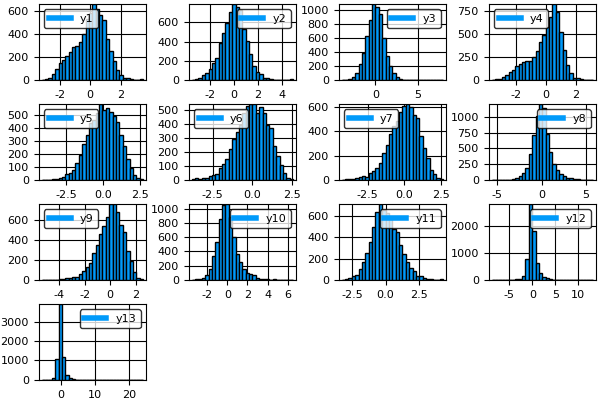

In [22]:
Y = convert(Matrix{Float64}, cg10k_trait[:, 3:15])
histogram(Y, layout = 13)

## Pre-processing data for heritability analysis

To prepare variance component model fitting, we form an instance of `VarianceComponentVariate`. The two variance components are $(2\Phi, I)$.

In [23]:
using VarianceComponentModels

# form data as VarianceComponentVariate
cg10kdata = VarianceComponentVariate(Y, (2Φgrm, eye(size(Y, 1))))
fieldnames(cg10kdata)

3-element Array{Symbol,1}:
 :Y
 :X
 :V

In [24]:
cg10kdata

VarianceComponentModels.VarianceComponentVariate{Float64,2,Array{Float64,2},Array{Float64,2},Array{Float64,2}}([-1.81573 -0.94615 … -1.02853 -0.394049; -1.2444 0.10966 … 1.09065 0.0256616; … ; 0.886626 0.487408 … -0.636874 -0.439825; -1.24394 0.213697 … 0.299931 0.392809],,(
[1.00583 0.00659955 … -0.000129257 -0.00562459; 0.00659955 0.99784 … 0.00181974 0.00691145; … ; -0.000129257 0.00181974 … 1.00197 0.00105123; -0.00562459 0.00691145 … 0.00105123 1.00158],

[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]))

Before fitting the variance component model, we pre-compute the eigen-decomposition of $2\Phi_{\text{GRM}}$, the rotated responses, and the constant part in log-likelihood, and store them as a `TwoVarCompVariateRotate` instance, which is re-used in various variane component estimation procedures.

In [25]:
# pre-compute eigen-decomposition (~50 secs on my laptop)
@time cg10kdata_rotated = TwoVarCompVariateRotate(cg10kdata)
fieldnames(cg10kdata_rotated)

 46.051433 seconds (726.58 k allocations: 1.024 GB, 0.45% gc time)


5-element Array{Symbol,1}:
 :Yrot    
 :Xrot    
 :eigval  
 :eigvec  
 :logdetV2

## Save intermediate results

We don't want to re-compute SnpArray and empirical kinship matrices again and again for heritibility analysis.

In [28]:
# Pkg.add("JLD")
#using JLD
#@save "cg10k.jld"
#whos()

                          Base  47039 KB     Module
                       BinDeps    218 KB     Module
                         Blosc     59 KB     Module
                    ColorTypes   8492 KB     Module
                        Colors   8414 KB     Module
                        Compat   8100 KB     Module
                         Conda   8491 KB     Module
                          Core  19714 KB     Module
                    DataArrays   8444 KB     Module
                    DataFrames   8940 KB     Module
                DataStructures    234 KB     Module
                        FileIO   9044 KB     Module
             FixedPointNumbers   8573 KB     Module
               FixedSizeArrays   8222 KB     Module
                          GZip   8003 KB     Module
                          HDF5   8809 KB     Module
                        IJulia 2082578 KB     Module
                         Ipopt     32 KB     Module
              IterativeSolvers    333 KB     Module
           

To load workspace

In [1]:
using SnpArrays, JLD, DataFrames, VarianceComponentModels, Plots
pyplot()
@load "cg10k.jld"
whos()

                          Base  39406 KB     Module
                       BinDeps    218 KB     Module
                         Blosc     59 KB     Module
                    ColorTypes   6371 KB     Module
                        Colors   6378 KB     Module
                        Compat   6099 KB     Module
                         Conda   6460 KB     Module
                          Core  15532 KB     Module
                    DataArrays   6388 KB     Module
                    DataFrames    649 KB     Module
                DataStructures    234 KB     Module
                        FileIO   6870 KB     Module
             FixedPointNumbers   6579 KB     Module
               FixedSizeArrays   6226 KB     Module
                          GZip   6004 KB     Module
                          HDF5   6657 KB     Module
                        IJulia   7125 KB     Module
                         Ipopt     32 KB     Module
              IterativeSolvers    333 KB     Module
            

## Heritability of single traits

We use Fisher scoring algorithm to fit variance component model for each single trait.

In [9]:
# heritability from single trait analysis
hST = zeros(13)
# standard errors of estimated heritability
hST_se = zeros(13)
# additive genetic effects
σ2a = zeros(13)
# enviromental effects
σ2e = zeros(13)

tic()
for trait in 1:13
    println(names(cg10k_trait)[trait + 2])
    # form data set for trait j
    traitj_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, trait], cg10kdata_rotated.Xrot, 
        cg10kdata_rotated.eigval, cg10kdata_rotated.eigvec, cg10kdata_rotated.logdetV2)
    # initialize model parameters
    traitj_model = VarianceComponentModel(traitj_data)
    # estimate variance components
    _, _, _, Σcov, _, _ = mle_fs!(traitj_model, traitj_data; solver=:Ipopt, verbose=false)
    σ2a[trait] = traitj_model.Σ[1][1]
    σ2e[trait] = traitj_model.Σ[2][1]
    @show σ2a[trait], σ2e[trait]
    h, hse = heritability(traitj_model.Σ, Σcov)
    hST[trait] = h[1]
    hST_se[trait] = hse[1]
end
toc()

Trait1
(σ2a[trait],σ2e[trait]) = (0.26104123217397623,0.7356884432614108)
Trait2
(σ2a[trait],σ2e[trait]) = (0.18874147380283665,0.8106899991616688)
Trait3
(σ2a[trait],σ2e[trait]) = (0.3185719276547346,0.6801458862875847)
Trait4
(σ2a[trait],σ2e[trait]) = (0.26556901333953487,0.7303588364945325)
Trait5
(σ2a[trait],σ2e[trait]) = (0.28123321193922013,0.7167989047155017)
Trait6
(σ2a[trait],σ2e[trait]) = (0.2829461149704479,0.7165629534396428)
Trait7
(σ2a[trait],σ2e[trait]) = (0.21543856403949083,0.7816211121585646)
Trait8
(σ2a[trait],σ2e[trait]) = (0.19412648732666096,0.8055277649986139)
Trait9
(σ2a[trait],σ2e[trait]) = (0.24789561127296741,0.7504615853619878)
Trait10
(σ2a[trait],σ2e[trait]) = (0.10007455815561886,0.899815277360586)
Trait11
(σ2a[trait],σ2e[trait]) = (0.16486778169300415,0.8338002257315682)
Trait12
(σ2a[trait],σ2e[trait]) = (0.08298660416198149,0.9158035668415443)
Trait13
(σ2a[trait],σ2e[trait]) = (0.05684248094794614,0.9423653381325947)
elapsed time: 0.19565668 seconds


0.19565668

In [10]:
# heritability and standard errors
[hST'; hST_se']

2×13 Array{Float64,2}:
 0.261898  0.188849   0.318981   …  0.165088   0.0830871  0.0568875
 0.079869  0.0867203  0.0741462     0.0887725  0.0944835  0.0953863

## Pairwise traits

Joint analysis of multiple traits is subject to intensive research recently. Following code snippet does joint analysis of all pairs of traits, a total of 78 bivariate variane component models.

In [12]:
# additive genetic effects (2x2 psd matrices) from bavariate trait analysis;
Σa = Array{Matrix{Float64}}(13, 13)
# environmental effects (2x2 psd matrices) from bavariate trait analysis;
Σe = Array{Matrix{Float64}}(13, 13)

tic()
for i in 1:13
    for j in (i+1):13
        println(names(cg10k_trait)[i + 2], names(cg10k_trait)[j + 2])
        # form data set for (trait1, trait2)
        traitij_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, [i;j]], cg10kdata_rotated.Xrot, 
            cg10kdata_rotated.eigval, cg10kdata_rotated.eigvec, cg10kdata_rotated.logdetV2)
        # initialize model parameters
        traitij_model = VarianceComponentModel(traitij_data)
        # estimate variance components
        mle_fs!(traitij_model, traitij_data; solver=:Ipopt, verbose=false)
        Σa[i, j] = traitij_model.Σ[1]
        Σe[i, j] = traitij_model.Σ[2]
        @show Σa[i, j], Σe[i, j]
    end
end
toc()

Trait1Trait2
(Σa[i,j],Σe[i,j]) = (
[0.260119 0.176216; 0.176216 0.187376],

[0.736589 0.583892; 0.583892 0.812033])
Trait1Trait3
(Σa[i,j],Σe[i,j]) = (
[0.261564 -0.0131268; -0.0131268 0.319057],

[0.73518 -0.121127; -0.121127 0.679679])
Trait1Trait4
(Σa[i,j],Σe[i,j]) = (
[0.26088 0.222614; 0.222614 0.265581],

[0.735846 0.599435; 0.599435 0.730347])
Trait1Trait5
(Σa[i,j],Σe[i,j]) = (
[0.260783 -0.147012; -0.147012 0.281877],

[0.735937 -0.254584; -0.254584 0.716176])
Trait1Trait6
(Σa[i,j],Σe[i,j]) = (
[0.260707 -0.129356; -0.129356 0.283188],

[0.736013 -0.231361; -0.231361 0.716329])
Trait1Trait7
(Σa[i,j],Σe[i,j]) = (
[0.260308 -0.140258; -0.140258 0.215081],

[0.736406 -0.197805; -0.197805 0.781985])
Trait1Trait8
(Σa[i,j],Σe[i,j]) = (
[0.261035 -0.0335296; -0.0335296 0.194143],

[0.735695 -0.126272; -0.126272 0.805512])
Trait1Trait9
(Σa[i,j],Σe[i,j]) = (
[0.263016 -0.204865; -0.204865 0.246796],

[0.733794 -0.30745; -0.30745 0.751544])
Trait1Trait10
(Σa[i,j],Σe[i,j]) = (
[0.260898 -0

7.752196517

## 3-trait analysis

Researchers want to jointly analyze traits 5-7. Our strategy is to try both Fisher scoring and MM algorithm with different starting point, and choose the best local optimum. We first form the data set and run Fisher scoring, which yields a final objective value -1.4700991+04.

In [13]:
traitidx = 5:7
# form data set
trait57_data = TwoVarCompVariateRotate(cg10kdata_rotated.Yrot[:, traitidx], cg10kdata_rotated.Xrot, 
    cg10kdata_rotated.eigval, cg10kdata_rotated.eigvec, cg10kdata_rotated.logdetV2)
# initialize model parameters
trait57_model = VarianceComponentModel(trait57_data)
# estimate variance components
@time mle_fs!(trait57_model, trait57_data; solver=:Ipopt, verbose=true)
trait57_model

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       78

Total number of variables............................:       12
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(,(
[0.281163 0.280014 0.232384; 0.280014 0.284899 0.220285; 0.232384 0.220285 0.212687],

[0.716875 0.66125 0.674025; 0.66125 0.714602 0.581433; 0.674025 0.581433 0.784324]),,Char[],Float64[],-Inf,Inf)

We then run the MM algorithm, starting from the Fisher scoring answer. MM finds an improved solution with objective value 8.955397e+03.

In [14]:
# trait59_model contains the fitted model by Fisher scoring now
@time mle_mm!(trait57_model, trait57_data; verbose=true)
trait57_model


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -1.470099e+04
       1  -1.470099e+04

  0.363096 seconds (539.27 k allocations: 20.482 MB, 2.19% gc time)


VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(,(
[0.281163 0.280014 0.232384; 0.280014 0.284899 0.220285; 0.232384 0.220285 0.212687],

[0.716875 0.66125 0.674025; 0.66125 0.714602 0.581433; 0.674025 0.581433 0.784324]),,Char[],Float64[],-Inf,Inf)

Do another run of MM algorithm from default starting point. It leads to a slightly better local optimum -1.470104e+04, slighly worse than the Fisher scoring result. Follow up anlaysis should use the Fisher scoring result.

In [15]:
# default starting point
trait57_model = VarianceComponentModel(trait57_data)
@time _, _, _, Σcov, = mle_mm!(trait57_model, trait57_data; verbose=true)
trait57_model


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -3.024751e+04
       1  -2.040338e+04
       2  -1.656127e+04
       3  -1.528591e+04
       4  -1.491049e+04
       5  -1.480699e+04
       6  -1.477870e+04
       7  -1.477026e+04
       8  -1.476696e+04
       9  -1.476499e+04
      10  -1.476339e+04
      20  -1.475040e+04
      30  -1.474042e+04
      40  -1.473272e+04
      50  -1.472677e+04
      60  -1.472215e+04
      70  -1.471852e+04
      80  -1.471565e+04
      90  -1.471336e+04
     100  -1.471152e+04
     110  -1.471002e+04
     120  -1.470879e+04
     130  -1.470778e+04
     140  -1.470694e+04
     150  -1.470623e+04
     160  -1.470563e+04
     170  -1.470513e+04
     180  -1.470469e+04
     190  -1.470432e+04
     200  -1.470400e+04
     210  -1.470372e+04
     220  -1.470347e+04
     230  -1.470326e+04
     240  -1.470307e+04
     250  -1.470290e+04
     260  -1.470275e+04
     270  -1.470262e+04
     280  -1.470250e+04
     290  -1.470239e+

VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(,(
[0.281188 0.280032 0.232439; 0.280032 0.284979 0.220432; 0.232439 0.220432 0.212922],

[0.71685 0.661232 0.67397; 0.661232 0.71452 0.581287; 0.67397 0.581287 0.784092]),,Char[],Float64[],-Inf,Inf)

Heritability from 3-variate estimate and their standard errors.

In [16]:
h, hse = heritability(trait57_model.Σ, Σcov)
[h'; hse']

2×3 Array{Float64,2}:
 0.281741   0.285122   0.21356  
 0.0778033  0.0773313  0.0841103

## 13-trait joint analysis

In some situations, such as studying the genetic covariance, we need to jointly analyze 13 traits. We first try the **Fisher scoring algorithm**.

In [17]:
# initialize model parameters
traitall_model = VarianceComponentModel(cg10kdata_rotated)
# estimate variance components using Fisher scoring algorithm
@time mle_fs!(traitall_model, cg10kdata_rotated; solver=:Ipopt, verbose=true)

This is Ipopt version 3.12.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    16653

Total number of variables............................:      182
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

LoadError: Base.LinAlg.PosDefException(25)

From the output we can see the Fisher scoring algorithm ran into some numerical issues. Let's try the **MM algorithm**.

In [19]:
# reset model parameters
traitall_model = VarianceComponentModel(cg10kdata_rotated)
# estimate variance components using Fisher scoring algorithm
@time mle_mm!(traitall_model, cg10kdata_rotated; verbose=true)


     MM Algorithm
  Iter      Objective  
--------  -------------
       0  -1.311337e+05
       1  -8.002195e+04
       2  -5.807051e+04
       3  -4.926234e+04
       4  -4.611182e+04
       5  -4.511727e+04
       6  -4.482798e+04
       7  -4.474410e+04
       8  -4.471610e+04
       9  -4.470285e+04
      10  -4.469355e+04
      20  -4.462331e+04
      30  -4.456960e+04
      40  -4.452834e+04
      50  -4.449652e+04
      60  -4.447178e+04
      70  -4.445237e+04
      80  -4.443699e+04
      90  -4.442467e+04
     100  -4.441470e+04
     110  -4.440656e+04
     120  -4.439985e+04
     130  -4.439427e+04
     140  -4.438959e+04
     150  -4.438564e+04
     160  -4.438229e+04
     170  -4.437941e+04
     180  -4.437694e+04
     190  -4.437480e+04
     200  -4.437294e+04
     210  -4.437131e+04
     220  -4.436989e+04
     230  -4.436863e+04
     240  -4.436751e+04
     250  -4.436652e+04
     260  -4.436564e+04
     270  -4.436485e+04
     280  -4.436414e+04
     290  -4.436351e+

(-44356.32043185692,VarianceComponentModels.VarianceComponentModel{Float64,2,Array{Float64,2},Array{Float64,2}}(,(
[0.273498 0.192141 … -0.128643 -0.098307; 0.192141 0.219573 … -0.0687355 -0.0433724; … ; -0.128643 -0.0687355 … 0.117185 0.0899824; -0.098307 -0.0433724 … 0.0899824 0.106354],

[0.723441 0.568135 … -0.0586259 -0.12469; 0.568135 0.77999 … 0.0236098 0.0464835; … ; -0.0586259 0.0236098 … 0.881707 0.551818; -0.12469 0.0464835 … 0.551818 0.893023]),,Char[],Float64[],-Inf,Inf),(
[0.0111652 0.0131052 … 0.012894 0.0127596; 0.0131077 0.0151572 … 0.0171615 0.0171431; … ; 0.0128941 0.0171614 … 0.0174141 0.0182039; 0.0127597 0.0171428 … 0.0182038 0.0187958],

[0.011228 0.0133093 … 0.0130109 0.012784; 0.0133113 0.0158091 … 0.0178685 0.0177999; … ; 0.0130107 0.0178687 … 0.017957 0.0187655; 0.0127836 0.0177997 … 0.0187654 0.0193582]),
[0.000124662 7.24629e-5 … -3.61414e-7 -1.40373e-5; 7.24483e-5 0.000171812 … -2.03586e-5 -3.26457e-6; … ; -3.87301e-7 -2.03778e-5 … 0.000352145 -1.48419e-5;

It converges after ~1000 iterations.

## Save analysis results

In [47]:
#using JLD
#@save "copd.jld"
#whos()